# Lab 5 Report: 
## Create Arthur Conan Doyle AI with RNN

### Name:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

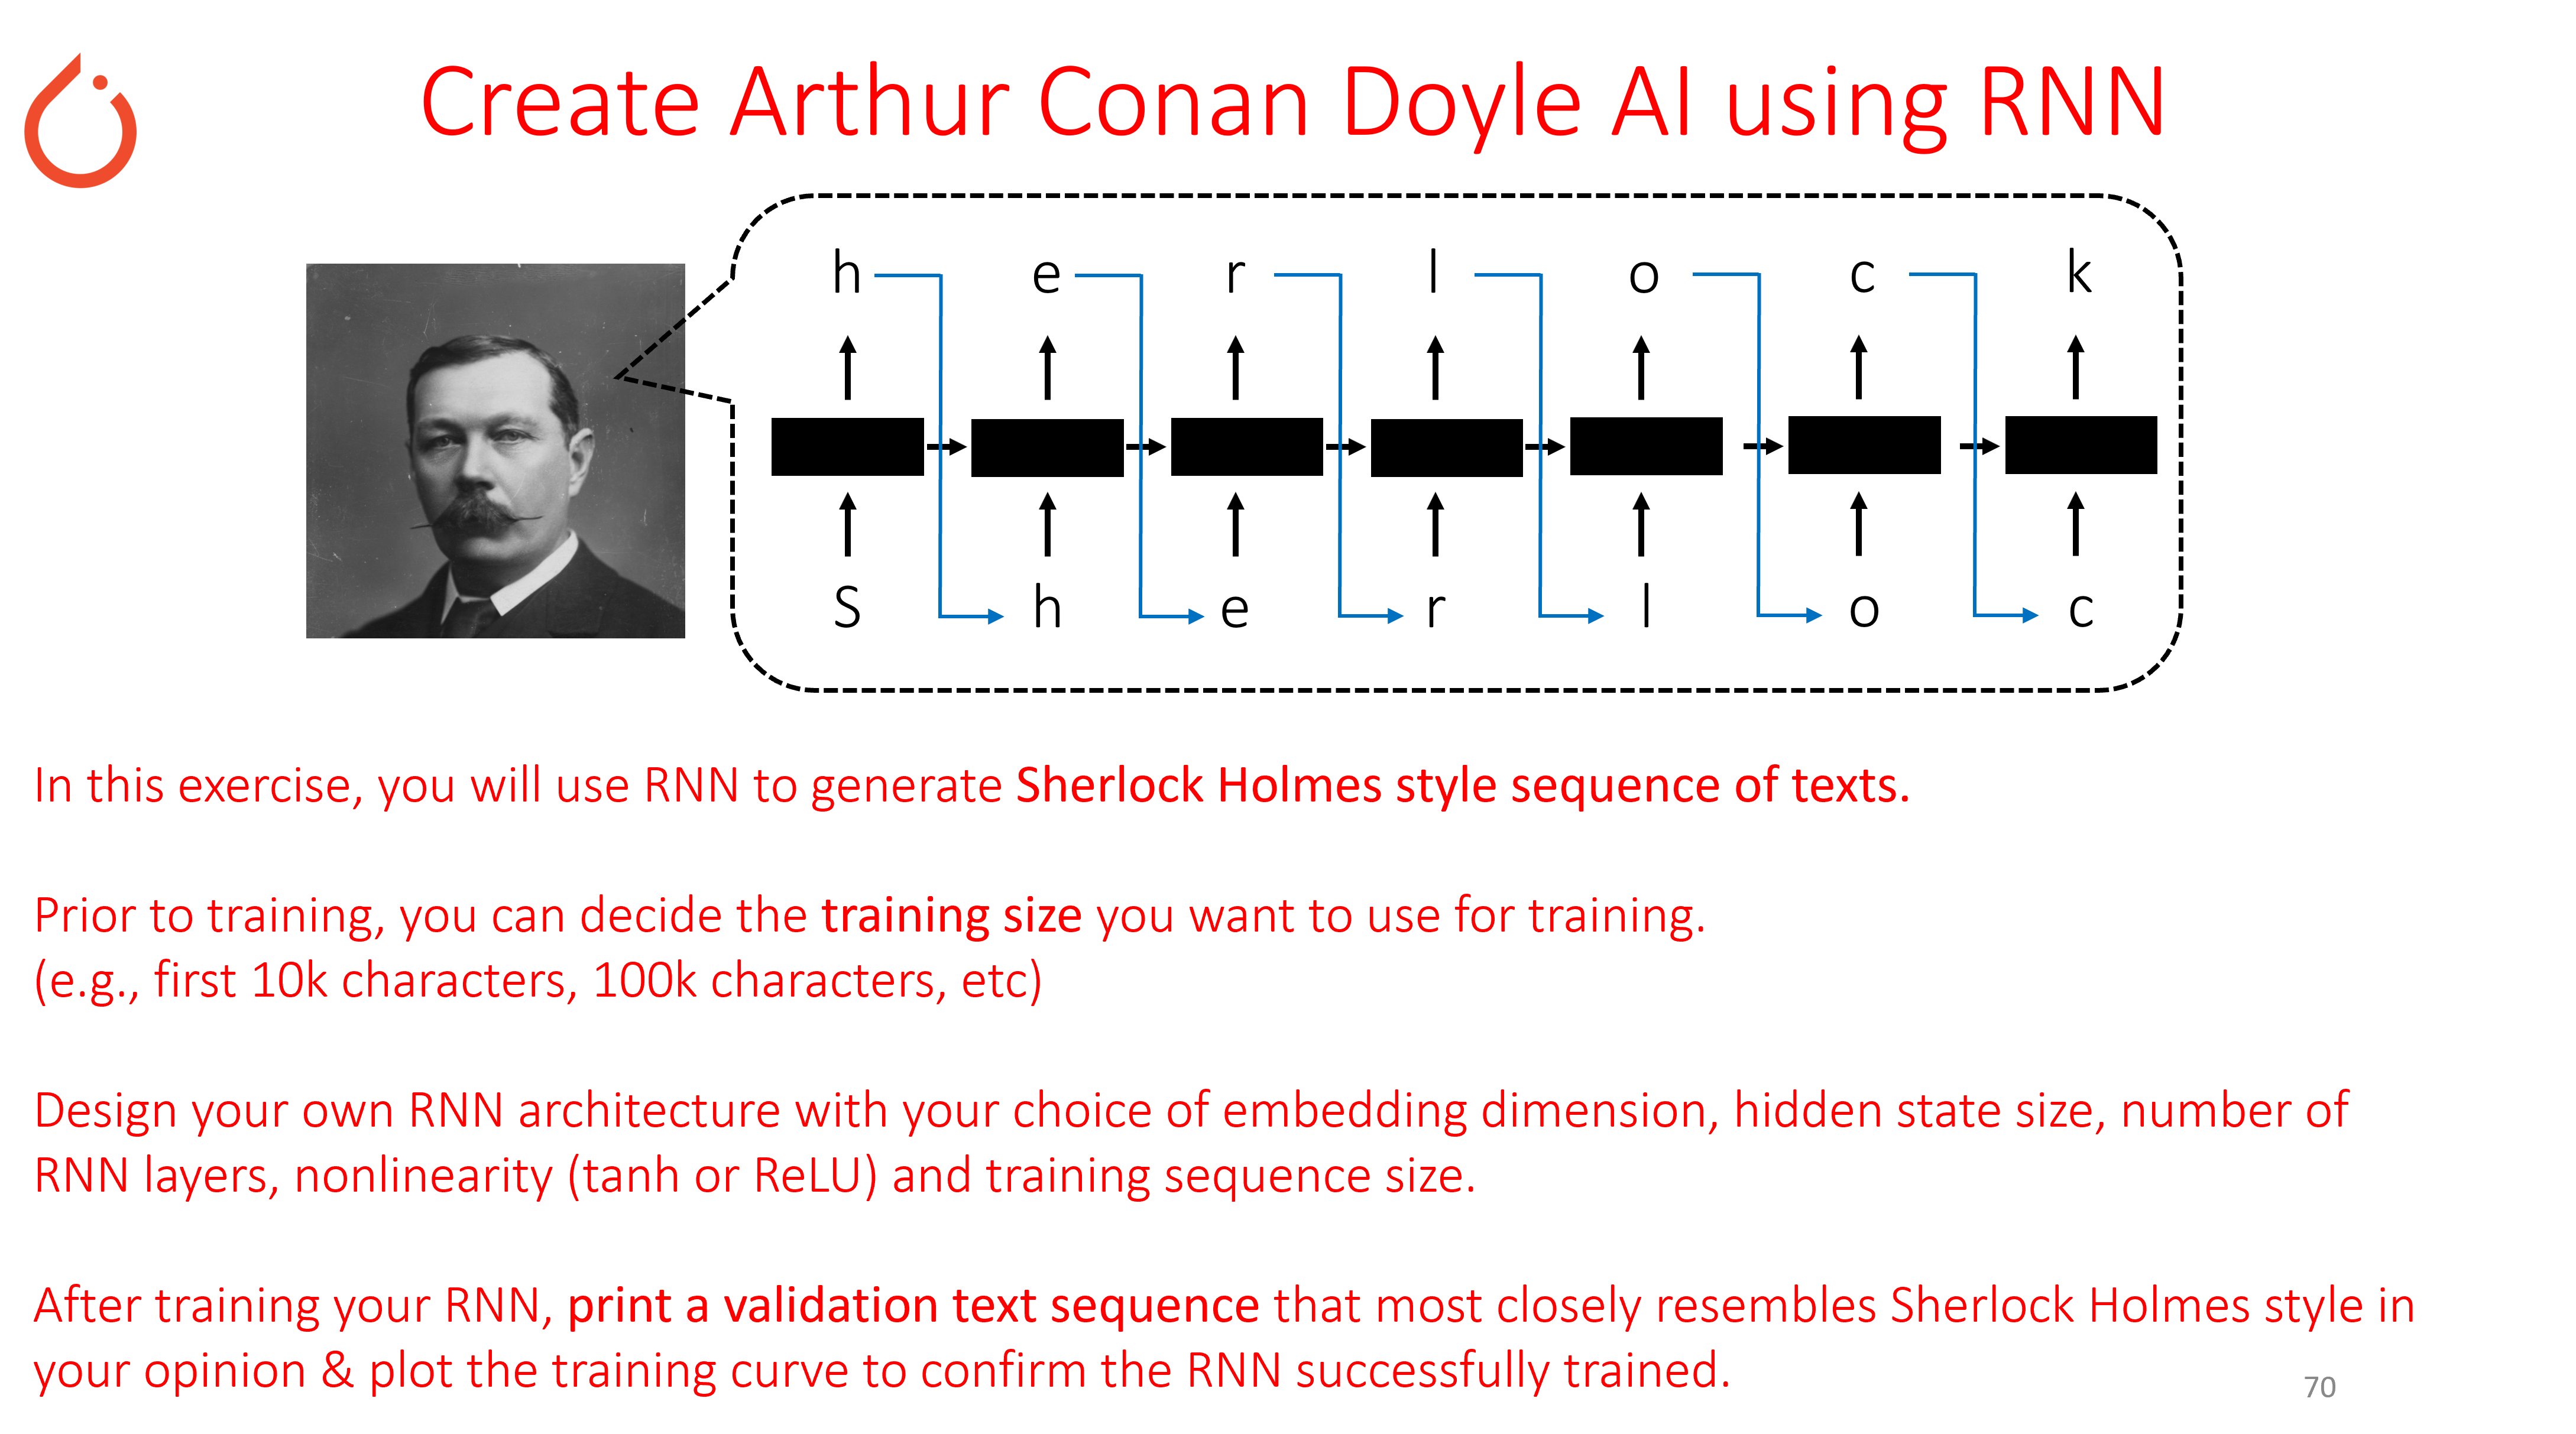

In [3]:
Image('lab5_exercise.png', width = 1000)

## Prepare Data

In [4]:
# You will train on the first N characters of the Sherlock Holmes book
# Pick the size of your training data, i.e. N
data_size_to_train = 10000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock_modify.txt', 'r').read()[:data_size_to_train]
# data = open('sherlock_chap1.txt', 'r').read()
# data=list(data)
# print(len(data))

# Find the set of unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 10000 characters, 61 unique


In [5]:
# Use Python Dictionary to map the characters to numbers and vice versa

# YOUR CODE HERE
character_to_num = {ch:i for i, ch in enumerate(characters)}
num_to_character = {i:ch for i, ch in enumerate(characters)}

print(character_to_num)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, ',': 5, '-': 6, '.': 7, '1': 8, '7': 9, '8': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'Y': 34, 'a': 35, 'b': 36, 'c': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'i': 43, 'j': 44, 'k': 45, 'l': 46, 'm': 47, 'n': 48, 'o': 49, 'p': 50, 'q': 51, 'r': 52, 's': 53, 't': 54, 'u': 55, 'v': 56, 'w': 57, 'x': 58, 'y': 59, 'z': 60}


In [6]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

# YOUR CODE HERE
data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

print(data[:5])

[1, 1, 1, 1, 1]


## Define Model

In [7]:
class CharRNN(torch.nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):
        
        super(CharRNN, self).__init__()
        
        # YOUR CODE HERE
        # Define embedding layer
        # num_embeddings = number of unique characters
        # embedding_dim = size of a vector that encodes each character
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

        #Define vanilla RNN cell
        #numlayers = Number of RNN cells to be stacked for deep-RNN
        # nonlinearity = Activation function to use
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity = 'relu')

        # decoder layer that takes hidden states as inputs and output probabilities for each character
        # output_size = number of unique characters
        self.decoder = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        
        # YOUR CODE HERE
        # Forward pass input sequence to embedding layer 
        embedding = self.embedding(input_seq)

        # RNN cell takes output of embedding layer + previous hidden state as inputs
        output, hidden_state = self.rnn(embedding, hidden_state)

        # Forward pass the RNN cell output to decoder to get the probabilities
        output = self.decoder(output)

        # hidden states need to be detached from computation graph to be re-used as input
        return output, hidden_state.detach()

## Define Hyperparameters

In [8]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings=vocab_size, embedding_dim=100, input_size=100, hidden_size=512, num_layers=3, output_size=vocab_size)

# Define learning rate and epochs
learning_rate = 0.001
epochs = 50

# Size of the input sequence to be used during training and validation
training_sequence_len = 50
validation_sequence_len = 200    

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn

CharRNN(
  (embedding): Embedding(61, 100)
  (rnn): RNN(100, 512, num_layers=3)
  (decoder): Linear(in_features=512, out_features=61, bias=True)
)

## Identify Tracked Values

In [9]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []
validation_output = np.full((epochs, 1), '', dtype='<U200')
# validation_output = []

## Train Model

In [10]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU
data = torch.unsqueeze(torch.tensor(data), dim=1)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    # Randomly select a starting character from first 100 characters in training set
    character_loc = np.random.randint(100)
    iteration = 0
    hidden_state = None

    while character_loc + training_sequence_len + 1 < data_size:  # loop continues until target_seq reaches end of the data
        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]
        
        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)
        
        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        
        # Append loss
        train_loss_list.append(loss.item())
        
        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update starting character for next sequence
        character_loc += training_sequence_len
        
        # Update iteration number
        iteration += 1
            
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))
   
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------
    
    #Initialize character location and hidden state for validation
    character_loc = 0
    hidden_state = None

    # Pick a random character from the dataset as an initial input to RNN
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")

    validation_tmp = ''
    with torch.no_grad():
        while character_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length
            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)
            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()

            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')
            # validation_tmp.append(num_to_character[character_num.item()])
            validation_tmp += num_to_character[character_num.item()]
            
            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()
            
            # Update the character location 
            character_loc += 1
    
    # YOUR CODE HERE
    validation_output[epoch] = validation_tmp

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  0 :  2.6217349444202442
----------------------------------------
souin tablewaspis in,ed bornor dou he. and., "ituley of tealllour, hoctos is a ling a sou wib of Treceildede we towengeid,.
 hout ung,
 "roveon
 "Alsoangeis anshad alt. of fou ty astint,
 "Gir baveres
----------------------------------------
Averaged Training Loss for Epoch  1 :  2.1790417792210026
----------------------------------------
 chacates to you thloned ham he." Yoo xeribn-foup is;ees occcof
 Alemkasing wemesn you sammed" which you?" "riverisawateer. Whe hin to lostebe with hove fuanstharn" havilg I stich the chave cave a lee
----------------------------------------
Averaged Training Loss for Epoch  2 :  1.9649866608658222
----------------------------------------
rre,
 Nood galvebrescome him tha drie fiield hove dor," I a peve hin it I line in?i ruppled, shivern not? Ansollair? Bo thin. "bessening him here I abbesy. "Ds my said-r bhit on his bes spuvismudic fo
------------------

## Visualize & Evaluate Model

In [11]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style
print(validation_output[49])

['eimen him credit. "You have been in\n Afgeant you should hardly have givenne a must for definite and exact knows what the objects in the army. baving complete a rast improved so far as to be able to wa']


In [12]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

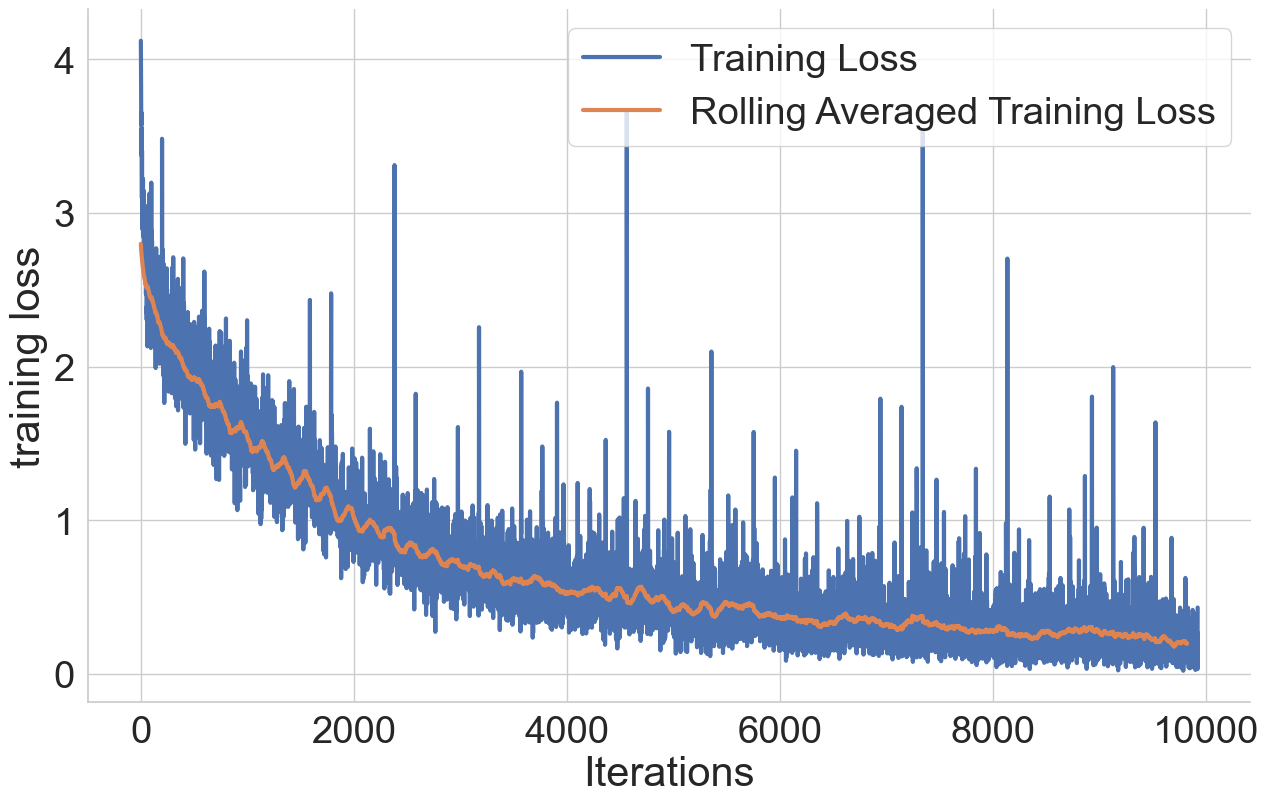

In [13]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()